
In this notebook, You will do amazon review classification with BERT [Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link].

It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
1. Preprocessing 
2. Creating a BERT model from the Tensorflow HUB.
3. Tokenization
4. getting the pretrained embedding Vector for a given review from the BERT.
5. Using the embedding data apply NN and classify the reviews.
6. Creating a Data pipeline for BERT Model. 

Instructions:

1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    - If you manipulate any, it will be considered as plagiarised. 
2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
5. We are giving instructions at each section if necessary, please follow them. 

Every Grader function has to return True.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount(mountpoint='/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from collections import Counter
from IPython.display import display

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

import os
import time
import re
import pickle
import datetime
import sys

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, 
    Dense, 
    Activation, 
    Dropout, 
    LSTM, 
    Conv1D, 
    Embedding, 
    Flatten
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    TensorBoard
)

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

Grader function 1

In [8]:
def grader_tf_version():
    assert((tf.__version__) > '2')
    return True

grader_tf_version()

True

In [9]:
project_path = '/content/drive/MyDrive/Applied-AI/Assignment-28'

In [10]:
sys.path.append(project_path)

In [11]:
!pip install sentencepiece --quiet

In [12]:
import tokenization as tkn

Part-1: Preprocessing

In [13]:
# Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(filepath_or_buffer=os.path.join(project_path, 'Reviews.csv'))
print(reviews.shape)

# Check the info of the dataset
reviews.info()

(568454, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [14]:
# Get only 2 columns - Text, Score
reviews = reviews[['Text', 'Score']]
print(reviews.shape)

# Drop the NAN values
reviews = reviews.dropna()
print(reviews.shape)
print(reviews.isnull().sum())

(568454, 2)
(568454, 2)
Text     0
Score    0
dtype: int64


- If score > 3, set score = 1
- If score <= 2, set score = 0
- If score == 3, remove the rows. 

In [15]:
reviews = reviews[reviews['Score'] != 3]
print(reviews.shape)

def binarize_scores(score):
    return 1 if score > 3 else 0

reviews['Score'] = reviews['Score'].apply(func=binarize_scores)
print(reviews['Score'].value_counts())

(525814, 2)
1    443777
0     82037
Name: Score, dtype: int64


Grader function 2

In [16]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1] == 443777)
    assert(temp_shape == True)
    return True

grader_reviews()

True

In [17]:
if not os.path.isfile(path=os.path.join(project_path, 'preprocessed.csv')):
    def get_wordlen(x):
        return len(x.split())

    reviews['len'] = reviews['Text'].apply(func=get_wordlen)
    reviews = reviews[reviews['len'] < 50]
    reviews = reviews.sample(n=100000, random_state=0)
    reviews = reviews[['Text', 'Score']]
    
    def clean_html(text):
        cleaner = re.compile('<.*>')
        text = re.sub(pattern=cleaner, repl='', string=text)
        return text

    reviews['Text'] = reviews['Text'].apply(func=clean_html)
    reviews.to_csv(path_or_buf=os.path.join(project_path, 'preprocessed.csv'), index=None)
    reviews = pd.read_csv(filepath_or_buffer=os.path.join(project_path, 'preprocessed.csv'))
else:
    print("File already exists.")
    reviews = pd.read_csv(filepath_or_buffer=os.path.join(project_path, 'preprocessed.csv'))

In [18]:
display(reviews.head())

,Text,Score
0,I currently deployed and coffee is life blood....,1
1,discovered petit cuisine at winn-dixie-bought ...,1
2,These beans are for use with intensive exercis...,1
3,These almonds just have a great flavor. Just ...,1
4,Popchips is a new product for me--ordered afte...,1


In [19]:
X = reviews['Text']
y = reviews['Score']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=33)
# X_train = X_train.dropna()
# y_train = y_train.dropna()
# X_test = X_test.dropna()
# y_test = y_test.dropna()

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80000,) (80000,)
(20000,) (20000,)


In [22]:
train_df = pd.DataFrame()
train_df['Text'] = X_train.values
train_df['Score'] = y_train

In [23]:
train_df = train_df.dropna()
print(train_df.shape)

(63974, 2)


In [24]:
test_df = pd.DataFrame()
test_df['Text'] = X_test.values
test_df['Score'] = y_test

In [25]:
test_df = test_df.dropna()
print(test_df.shape)

(3911, 2)


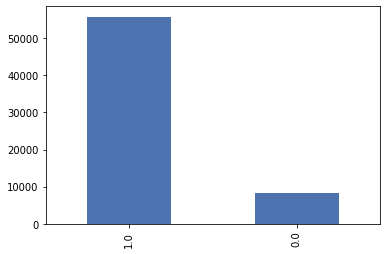

In [26]:
train_df['Score'].value_counts().plot(kind='bar')
plt.show()

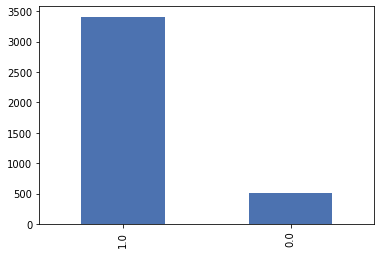

In [27]:
test_df['Score'].value_counts().plot(kind='bar')
plt.show()

Part-2: Creating BERT Model

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.

In [28]:
# Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# Maximum length of a seq in the data we have, for now i am making it as 55. You can change this.
max_seq_length = 55

# BERT takes 3 inputs

# This is input words. Sequence of words represented as integers.
input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

# Mask vector if you are padding anything.
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

# Segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
# If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and second seq segment vector are 1's.
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

# Bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

# Bert model
# We are using only pooled output not sequence out. 
# If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510.
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [29]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [30]:
bert_model.output.shape

TensorShape([None, 768])

Part-3: Tokenization

In [31]:
# Getting vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [32]:
print(vocab_file)

b'/tmp/tfhub_modules/03d6fb3ce1605ad9e5e9ed5346b2fb9623ef4d3d/assets/vocab.txt'


In [33]:
print(do_lower_case)

True


In [34]:
tokenizer = tkn.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

<font size=4>Grader function 3 </font>

In [35]:
def grader_tokenize(tokenizer):
    out = False
    try:
        out = ('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert( out == True)
    return out

grader_tokenize(tokenizer)

True

1. Create train and test tokens `(X_train_tokens, X_test_tokens)` from `(X_train, X_test)` using `tokenizer`.
2. Add `'[CLS]'` at start of the Tokens and `'[SEP]'` at the end of the tokens.
3. Maximum number of tokens is 55 (we already given this to BERT layer above) so shape is `(None, 55)`.
4. If it is less than 55, add `'[PAD]'` token else truncate the tokens length (similar to padding).
5. Based on padding, create the mask for Train and Test (1 for real token, 0 for `'[PAD]'`).
6. It will be same shape as input tokens `(None, 55)` save those in `X_train_mask`, `X_test_mask`.
7. Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also `(None, 55)`.
8. Type of all the above arrays should be numpy arrays.
9. After execution of this cell, you have to get - 
    - `(X_train_tokens, X_train_mask, X_train_segment)`
    - `(X_test_tokens, X_test_mask, X_test_segment)`

Example

<img src='https://i.imgur.com/5AhhmgU.png'>

In [36]:
def get_tokens_mask_segment_from_text(text, tokenizer=tokenizer, max_len=max_seq_length):
    tokens = tokenizer.tokenize(text=text)

    if len(tokens) > (max_len - 2):
        # To make sure after adding '[CLS]' and '[SEP]', the length remains same as max_len.
        tokens = tokens[0 : (max_len - 2)]
    
    tokens = ['[CLS]', *tokens, '[SEP]']
    tokens_ids = tokenizer.convert_tokens_to_ids(tokens=tokens)
    
    # Post padding the tokens.
    if (len(tokens) < max_len):
        tokens_ids = tokens_ids + ([0] * (max_len - len(tokens_ids)))
    
    mask = ([1] * len(tokens)) + ([0] * (max_len - len(tokens)))
    segment = ([0] * max_len)
   
    return np.array(tokens_ids), np.array(mask), np.array(segment)

In [37]:
def get_tokens_mask_segment_for_corpus(documents):
    documents_token_ids = []
    documents_masks = []
    documents_segments = []

    for text in tqdm(documents):
        t_id, m, s = get_tokens_mask_segment_from_text(text=text)
        documents_token_ids.append(t_id)
        documents_masks.append(m)
        documents_segments.append(s)
    
    documents_token_ids = np.array(documents_token_ids)
    documents_masks = np.array(documents_masks)
    documents_segments = np.array(documents_segments)
    
    return documents_token_ids, documents_masks, documents_segments

In [40]:
if not os.path.isfile(path=os.path.join(project_path, 'train_data.pkl')):
    with open(file=os.path.join(project_path, 'train_data.pkl'), mode='wb') as tr_data:
        X_train_tokens, X_train_masks, X_train_segments = get_tokens_mask_segment_for_corpus(documents=train_df['Text'])
        pickle.dump(obj=(train_df['Text'], X_train_tokens, X_train_masks, X_train_segments, train_df['Score']), file=tr_data)
else:
    print('File already exists.')
    with open(file=os.path.join(project_path, 'train_data.pkl'), mode='rb') as tr_data:
        X_train, X_train_tokens, X_train_masks, X_train_segments, y_train = pickle.load(file=tr_data)

File already exists.


In [41]:
if not os.path.isfile(path=os.path.join(project_path, 'test_data.pkl')):
    with open(file=os.path.join(project_path, 'test_data.pkl'), mode='wb') as te_data:
        X_test_tokens, X_test_masks, X_test_segments = get_tokens_mask_segment_for_corpus(documents=test_df['Text'])
        pickle.dump(obj=(test_df['Text'], X_test_tokens, X_test_masks, X_test_segments, test_df['Score']), file=te_data)
else:
    print('File already exists.')
    with open(file=os.path.join(project_path, 'test_data.pkl'), mode='rb') as te_data:
        X_test, X_test_tokens, X_test_masks, X_test_segments, y_test = pickle.load(file=te_data)

File already exists.


<font size=4>Grader function 4 </font>

In [42]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = ((X_train_tokens.shape[1] == max_seq_length) and 
                       (X_train_masks.shape[1] == max_seq_length) and 
                       (X_train_segments.shape[1] == max_seq_length))
        
        segment_temp = not np.any(X_train_segments)
        
        mask_temp = np.sum(X_train_masks==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]']) == X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]']) == X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False

    assert(out == True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [43]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = ((X_test_tokens.shape[1] == max_seq_length) and 
                       (X_test_masks.shape[1] == max_seq_length) and 
                       (X_test_segments.shape[1] == max_seq_length))
        
        segment_temp = not np.any(X_test_segments)
        
        mask_temp = np.sum(X_test_masks == 0) == np.sum(X_test_tokens == 0)
        
        no_cls = np.sum(X_test_tokens == tokenizer.vocab['[CLS]']) == X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens == tokenizer.vocab['[SEP]']) == X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False

    assert(out == True)
    return out

grader_alltokens_test()

True

Part-4: Getting Embeddings from BERT Model

We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.

In [47]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [48]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [50]:
if not os.path.isfile(path=os.path.join(project_path, 'train_final_output.pkl')):
    X_train_pooled_output = bert_model.predict(x=[X_train_tokens, X_train_masks, X_train_segments])
    pickle.dump(obj=X_train_pooled_output, file=open(os.path.join(project_path, 'train_final_output.pkl'), 'wb'))
else:
    print('File already exists.')
    X_train_pooled_output = pickle.load(file=open(os.path.join(project_path, 'train_final_output.pkl'), mode='rb'))

2000/2000 [==============================] - 236s 118ms/step


In [51]:
if not os.path.isfile(path=os.path.join(project_path, 'test_final_output.pkl')):
    X_test_pooled_output = bert_model.predict(x=[X_test_tokens, X_test_masks, X_test_segments])
    pickle.dump(obj=X_test_pooled_output, file=open(os.path.join(project_path, 'test_final_output.pkl'), 'wb'))
else:
    print('File already exists.')
    X_test_pooled_output = pickle.load(file=open(os.path.join(project_path, 'test_final_output.pkl'), mode='rb'))

123/123 [==============================] - 14s 119ms/step


<font size=4>Grader function 6 </font>

In [52]:
def greader_output():
    assert(X_train_pooled_output.shape[1] == 768)
    assert(len(y_train) == len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1] == 768)
    assert(len(y_test) == len(X_test_pooled_output))
    assert(len(y_train.shape) == 1)
    assert(len(X_train_pooled_output.shape) == 2)
    assert(len(y_test.shape) == 1)
    assert(len(X_test_pooled_output.shape) == 2)
    return True

greader_output()

True

Part-5: Training a NN with 768 features

1. Create a NN and train the NN. 
2. You have to use AUC as metric. Do not use tf.keras.metrics.AUC. You have to write custom code for AUC and print it at the end of each epoch. 
3. You can use any architecture you want. 
4. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
5. Print the loss and metric at every epoch. 
6. You have to submit without overfitting and underfitting. 

In [53]:
def auc(y_true, y_pred):
    func = lambda y_true, y_pred : metrics.roc_auc_score(y_true, y_pred)
    score = tf.numpy_function(func=func, inp=[y_true, y_pred], Tout=tf.double, name='custom_auc')
    return score

In [54]:
tf.keras.backend.clear_session()

input_layer = Input(shape=(X_train_pooled_output.shape[1],))

flat_1 = Flatten()(input_layer)

dense_1 = Dense(units=64, activation='relu')(flat_1)
dense_2 = Dense(units=32, activation='relu')(dense_1)

output_layer = Dense(units=2, activation='softmax')(dense_2)

model = Model(inputs=input_layer, outputs=output_layer)
filepath = "model_save/best_model_nlp_tl.h5"

optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', auc])

model_save_callback = ModelCheckpoint(filepath=filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

In [55]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 51,362
Trainable params: 51,362
Non-trainable params: 0
_________________________________________________________________


In [56]:
y_train_categorical = tf.keras.utils.to_categorical(y=y_train, num_classes=2)
y_test_categorical = tf.keras.utils.to_categorical(y=y_test, num_classes=2)

In [57]:
callbacks = [model_save_callback]

tracker = model.fit(x=X_train_pooled_output, 
                    y=y_train_categorical, 
                    epochs=30, 
                    validation_data=(X_test_pooled_output, y_test_categorical), 
                    batch_size=256, 
                    callbacks=callbacks)

Epoch 1/30
240/250 [===========================>..] - ETA: 0s - loss: 0.4110 - accuracy: 0.8660 - auc: 0.5011
Epoch 1: val_auc improved from -inf to 0.51644, saving model to model_save/best_model_nlp_tl.h5
250/250 [==============================] - 2s 5ms/step - loss: 0.4108 - accuracy: 0.8658 - auc: 0.5014 - val_loss: 0.3906 - val_accuracy: 0.8719 - val_auc: 0.5164
Epoch 2/30
241/250 [===========================>..] - ETA: 0s - loss: 0.3871 - accuracy: 0.8709 - auc: 0.5040
Epoch 2: val_auc did not improve from 0.51644
250/250 [==============================] - 1s 5ms/step - loss: 0.3860 - accuracy: 0.8714 - auc: 0.5040 - val_loss: 0.3964 - val_accuracy: 0.8719 - val_auc: 0.4990
Epoch 3/30
245/250 [============================>.] - ETA: 0s - loss: 0.3857 - accuracy: 0.8717 - auc: 0.5109
Epoch 3: val_auc did not improve from 0.51644
250/250 [==============================] - 1s 5ms/step - loss: 0.3862 - accuracy: 0.8714 - auc: 0.5108 - val_loss: 0.3850 - val_accuracy: 0.8719 - val_auc: 

In [58]:
tracker.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

In [63]:
def plot_model_performance(tracker):
    x = list(range(1, 31))

    plt.figure(figsize=(18, 6))
    
    plt.subplot(131)
    plt.plot(x, tracker.history['accuracy'], 'r--', label='train')
    plt.plot(x, tracker.history['val_accuracy'], 'g--', label='validation')
    plt.title('Accuracy Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(132)
    plt.plot(x, tracker.history['loss'], 'r--', label='train')
    plt.plot(x, tracker.history['val_loss'], 'g--', label='validation')
    plt.title('Loss Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Loss')
    plt.legend()
    plt.grid()

    plt.subplot(133)
    plt.plot(x, tracker.history['auc'], 'r--', label='train')
    plt.plot(x, tracker.history['val_auc'], 'g--', label='validation')
    plt.title('AUC Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Loss')
    plt.legend()
    plt.grid()

    plt.show()

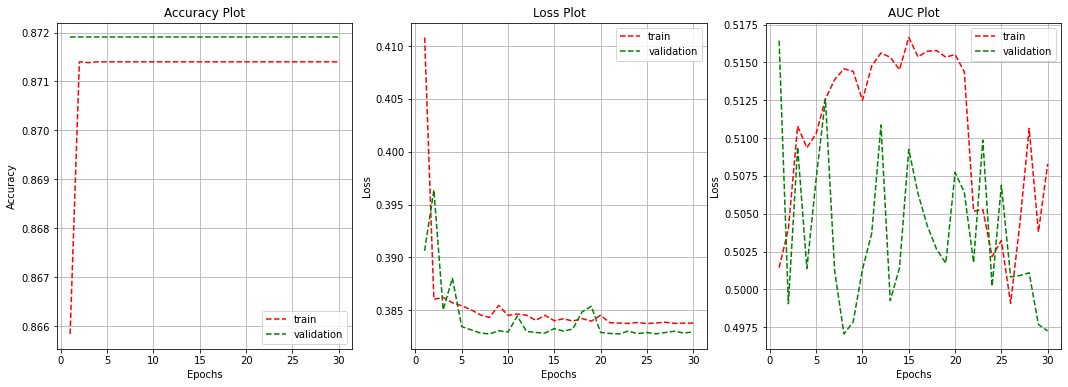

In [64]:
plot_model_performance(tracker=tracker)

In [65]:
model.load_weights(filepath=filepath)

Part-6: Creating a Data pipeline for BERT Model


1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a>

In [66]:
test_df = pd.read_csv(filepath_or_buffer=os.path.join(project_path, 'test.csv'))

In [67]:
test_df.head()

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."
3,I love this soup. It's great as part of a meal...
4,Getting ready to order again. These are great ...


1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
    - Remove all the html tags
    - Now do tokenization [Part 3 as mentioned above]
    - Create tokens,mask array and segment array
    - Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
    - Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.
4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

In [68]:
def pipeline(df, model):
    cleaner = re.compile('<.*?>') 

    def clean_html(text):
        text = re.sub(pattern=cleaner, repl='', string=text)
        return text
    
    # removing html tags
    df['Text'] = df['Text'].apply(func=clean_html)
    # creating tokens, masks, and segments
    df_tokens, df_masks, df_segments = get_tokens_mask_segment_for_corpus(documents=df['Text'])
    # getting the embeddings
    df_pooled_output = bert_model.predict(x=[df_tokens, df_masks, df_segments])
    print(df_pooled_output.shape)
    # predictions
    probas = model.predict(x=df_pooled_output)
    preds = probas.argmax(axis=-1)
    return preds

In [69]:
predictions = pipeline(df=test_df, model=model)

100%|██████████| 352/352 [00:00<00:00, 1959.46it/s]


11/11 [==============================] - 2s 117ms/step
(352, 768)
11/11 [==============================] - 0s 1ms/step


In [70]:
test_df['labels'] = predictions

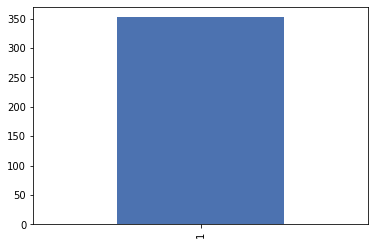

In [71]:
test_df['labels'].value_counts().plot(kind='bar')

Please write your observations at the end of notebook and  explain each and every step you followed in solving this assignment.

1. This is binary classification problem.
2. Basic preprocessing techniques were applied such as html cleaner and lower case and removing nan values.
3. One pointer, though we removed nan values from the dataset, when we split the dataset, we were able to see nan values again. Hence, I removed nan values again, which reduced the dataset size. If we don't remove, the tokenizer would raise an exception.
4. Using BERT model, we obtained positional embeddings, masks and segments. All these are adjusted during training.
7. Final output of BERT model is fed FFNN to get final predicitions.
8. We used auc as a metric in order to check the model performance.